In [1]:
import os

os.chdir("../../")  # Ensure Current working directory is top level folder where venv is.

import os.path
import math

import numpy as np
import matplotlib.pyplot as plt

from source.models.noise.noise_sweep import NoiseSweep
from source.models.noise.simple_noise_packet_psd import SimpleNoisePacketPSD
from source.services.fits_data_unpack_service import FitsDataUnpackService
from source.services.fits_file_load_service import FitsFileLoadService
from source.services.hidfmux_pkl_file_load_service import HidfmuxFileLoadService
from source.util import resonator_noise_analysis_tools
from source.util import noise_multiplication_method_tools
from source.util import lekid_analysis_tools
from scipy.signal import correlate
from scipy.signal import find_peaks

In [2]:

multi_tone_directory=r"C:\Users\c2047423\OneDrive - Cardiff University\Documents\Gethin - PhD\Device Data\SPT-SLIM\v2_anlw001_ppcaps\Ice_board_data\140mK_0p001_amp"
dut="slim_v2_anlw001_ppcaps"
temperature=0.14
save_figures=False


In [3]:
multi_tone_timestreams = HidfmuxFileLoadService.load_multi_tone_pkl_timestreams(timestream_directory=multi_tone_directory)

1/101 Timestreams loaded
2/101 Timestreams loaded
3/101 Timestreams loaded
4/101 Timestreams loaded
5/101 Timestreams loaded
6/101 Timestreams loaded
7/101 Timestreams loaded


In [4]:
from lmfit import Model
from lmfit import Parameters

def skewed_lorentzian(
    frequency_array: np.ndarray,
    f0: float,
    qi: float,
    qc_real: float,
    qc_imag: float,
    amp: float,
) -> np.ndarray:
    """
    Model of a skewed lorentzian using a complex qc.

    :param frequency_array: Array of N frequency points.
    :param f0: Resonant frequency
    :param qi: Loss quality factor
    :param qc_real: Real coupling quality factor
    :param qc_imag: Imaginary coupling quality factor
    :param amp: Amplitude
    :return:
    """

    x = (frequency_array - f0) / f0
    qc = (abs(qc_real + 1j * qc_imag) ** 2 / qc_real,)
    qr = 1.0 / ((1.0 / qc[0]) + (1.0 / qi))
    return abs(amp * (1 - qr / (qc_real + 1j * qc_imag) / (1 + 2j * qr * x)))


def fit_skewed_lorentzian(
    frequency_array: np.array,
    data_array: np.array,
    qc_guess: float,
    qi_guess: float,
    f0_guess: float or None,
    fit_fraction: float,
    normalise=True,
    plot_graph=True,
    plot_db=True,
    plot_title="",
) -> dict:
    """
    Function to fit a skewed lorentzian model to S21 magnitude data.\n
    Returns dictionary of fit parameters with standard errors, e.g. result_dict["qr"] = [value, error].
    Result dictionary keys: dict_keys(['f0', 'qr', 'qc_real', 'qc_imag', 'amp', 'qc', 'qi', 'mean_3_sigma_percentage_uncertainty']).
    Where the mean percentage uncertainty is just a single float value.

    :param frequency_array: Array of N frequency points.
    :param data_array: Magnitude array of N S21 data points.
    :param qc_guess: Guess for the qr of the lorentzian.
    :param qi_guess: Guess for the loss q of the lorentzian.
    :param f0_guess: Guess for the resonant frequency.
    :param fit_fraction: Fraction of data points to fit to (between 0 and 1). 1 being 100% of the data.
    :param normalise: Boolean to normalise the data_array array before fitting.
    :param plot_graph: Boolean command to plot amp graph of the fit.
    :param plot_db: Boolean command to plot S Parameter in plot_db.
    :param plot_title: Title to give to plot. Default is an empty string.

    """

    # TODO Add logic to identify colliding kids.
    if normalise:
        data_array = data_array / np.max(data_array)

    f0_index = np.argmin(data_array)  # index of minimum point.
    resonance_data_points = round(
        (len(data_array) * fit_fraction) / 2
    )  # define number of data points either side of resonance to sample
    start_index = f0_index - resonance_data_points
    end_index = f0_index + resonance_data_points

    if start_index < 0:
        end_index -= start_index  # Add clipped data points to end index
        start_index = 0

    if end_index > frequency_array.size - 1:
        start_index -= (end_index - frequency_array.size - 1) # Add clipped data points to start index
        end_index = -1


    # Define model:
    l_model = Model(skewed_lorentzian)

    # Allow for user input f0_guess
    f0_first_guess = frequency_array[f0_index]
    if f0_guess is not None:
        f0_first_guess = f0_guess

    # Define Parameters:
    params = Parameters()
    params.add("f0", value=f0_first_guess, vary=True)
    params.add("qi", value=qi_guess, vary=True, min=0)
    params.add("qc_real", value=qc_guess, vary=True, min=0)
    params.add("qc_imag", value=100.0, vary=True)
    # Guesses background level as mean of data_array.
    params.add("amp", value=data_array[-1], vary=True)

    # l_model.fit
    result = l_model.fit(
        data=np.abs(data_array)[start_index:end_index],
        params=params,
        frequency_array=frequency_array[start_index:end_index],
    )

    # uncertainty interval to 3 sigma:
    uncertainty = result.eval_uncertainty(sigma=3)
    upper_uncertainty_line = result.best_fit + uncertainty
    lower_uncertainty_line = result.best_fit - uncertainty

    mean_percentage_confidence = np.mean((uncertainty/result.best_fit) * 100)

    result_dict = {}
    for name, parameter in result.params.items():
        result_dict[name] = [parameter.value, parameter.stderr]

    result_dict["mean_3_sigma_percentage_uncertainty"] = mean_percentage_confidence

    try:
        result_dict["qc"] = [
            abs(result_dict["qc_real"][0] + 1j * result_dict["qc_imag"][0]) ** 2
            / result_dict["qc_real"][0],
            np.sqrt(
                result_dict["qc_real"][1] ** 2
                + (
                    2
                    * result_dict["qc_imag"][1]
                    * result_dict["qc_imag"][0]
                    / result_dict["qc_real"][0]
                )
                ** 2
                + result_dict["qc_real"][1]
                * result_dict["qc_imag"][0] ** 2
                / result_dict["qc_real"][0] ** 2
            ),
        ]
    except TypeError:
        print(
            f"{plot_title} - Possible error: The fit value for Qc has None type standard errors."
        )
        result_dict["qc"] = [
            abs(result_dict["qc_real"][0] ** 2 + 1j * result_dict["qc_imag"][0])
            / result_dict["qc_real"][0],
            None,
        ]

    qr = 1 / ((1 / result_dict["qc"][0]) + (1 / result_dict["qi"][0]))
    try:
        result_dict["qr"] = [
            qr,
            np.sqrt(
                qr**4
                * (
                    result_dict["qc"][1] ** 2 / result_dict["qc"][0] ** 4
                    + result_dict["qi"][1] ** 2 / result_dict["qi"][0] ** 4
                )
            ),
        ]
    except TypeError:
        print(
            f"{plot_title} - Possible error: The fit value for Qi or Qc has None type standard errors."
        )
        result_dict["qr"] = [qr, None]

    if plot_graph:

        f_array = np.linspace(
            start=frequency_array[start_index],
            stop=frequency_array[end_index],
            num=1000000,
        )

        lorentzian_fit = skewed_lorentzian(
            frequency_array=f_array,
            f0=result_dict["f0"][0],
            qi=result_dict["qi"][0],
            qc_real=result_dict["qc_real"][0],
            qc_imag=result_dict["qc_imag"][0],
            amp=result_dict["amp"][0],
        )


        if plot_db:
            y_label = "S21 Magnitude (plot_db)"
            data_array = 20 * np.log10(data_array)
            lorentzian_fit = 20 * np.log10(lorentzian_fit)
            uncertainty = 20 * np.log10(uncertainty)
            upper_uncertainty_line = 20 * np.log10(upper_uncertainty_line)
            lower_uncertainty_line = 20 * np.log10(lower_uncertainty_line)

        if not plot_db:
            y_label = "S21 Magnitude"

        plt.figure(figsize=(8, 6))
        plt.plot(
            frequency_array,
            data_array,
            linestyle="none",
            marker="o",
            markersize=2,
            color="b",
            label="Data",
        )
        plt.plot(
            f_array,
            lorentzian_fit,
            linestyle="-",
            color="r",
            label="Best fit:\nqr=%0.2e\nqc=%0.2e\nQi=%0.2e\nf0=%0.2e"
            % (
                result_dict["qr"][0],
                result_dict["qc"][0],
                result_dict["qi"][0],
                result_dict["f0"][0],
            ),
        )
        plt.fill_between(frequency_array[start_index:end_index], upper_uncertainty_line, lower_uncertainty_line, color='#888888', label="3$\sigma$ Confidence Interval")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel(y_label)
        plt.title(plot_title)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return result_dict

In [5]:
min_qr = 1e3
max_qr = 1e6

percentage_3_sigma_uncertainty_threshold = 0.35

good_kid_array = np.empty_like(multi_tone_timestreams.tone_name_array, dtype=bool)

for count, sweep in enumerate(multi_tone_timestreams.sweep_data_array):

    magnitude_array = np.abs(sweep.get_iq_array())

    good_kid_array[count] = lekid_analysis_tools.is_good_kid(
        frequency_array=sweep.frequency_array,
        data_array=magnitude_array,
        qc_guess=1e5,
        qi_guess=1e5,
        f0_guess=None,
        fit_fraction=0.7,
        percentage_3_sigma_uncertainty_threshold=percentage_3_sigma_uncertainty_threshold,
        min_qr=1e3,
        max_qr=1e6,
        normalise=False,
        plot_graph=False,
        plot_db=True,
    )
    

0.21468299266148275
0.22372670479718587
0.3964721927587408
Bad KID: Fit has too large an uncertainty
0.250223810945787
0.4266479933945511
Bad KID: Fit has too large an uncertainty
0.3029900668062379
0.398874086148955
Bad KID: Fit has too large an uncertainty


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


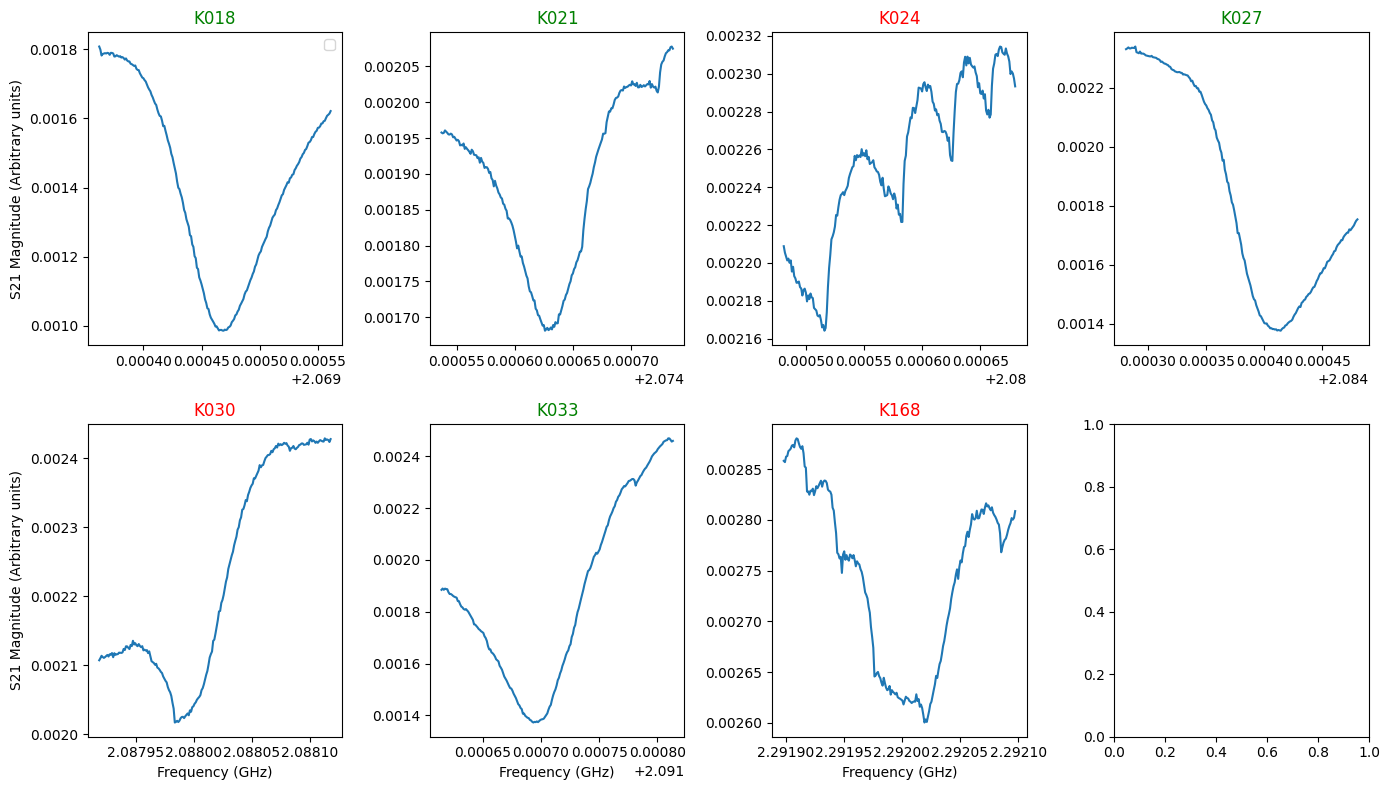

In [6]:
n_timestreams = multi_tone_timestreams.sweep_data_array.shape[0]
n_columns = 4
n_rows = math.ceil(n_timestreams / n_columns)

row = 0
column = 0
figures, axes = plt.subplots(n_rows, n_columns, sharex=False, figsize=(14, n_rows*4))
for count, sweep in enumerate(multi_tone_timestreams.sweep_data_array):

    if good_kid_array[count] == True:
        color = "g"
    else:
        color = "r"

    axes[row][column].plot(sweep.frequency_array * 1e-9, np.abs(sweep.get_iq_array()))
    axes[row][column].set_title(multi_tone_timestreams.tone_name_array[count], color=color)

    if column == 0:
        axes[row][column].set_ylabel("S21 Magnitude (Arbitrary units)")

    if row == n_rows - 1:
        axes[row][column].set_xlabel("Frequency (GHz)")

    column += 1
    if column == 4:
        column = 0
        row += 1
axes[0][0].legend()
plt.tight_layout()
plt.show()